In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from constants import *
%matplotlib inline

# North Carolinea CRDC Exploratory Vis

### Load Data

In [3]:
DATA_FILE = 'data (download CSVs here)/crdc-data-with-lat-long.csv'
crdc_data = pd.read_csv(
    DATA_FILE,
    usecols=COLS_WITH_NEEDED_DATA,
    low_memory=False,
    encoding="ISO-8859-1"
)

In [5]:
df = crdc_data[crdc_data['LEA_STATE_NAME'] == 'NORTH CAROLINA']
df

,LEA_STATE_NAME,LEAID,LEA_NAME,SCH_NAME,SCH_ENR_HI_M,SCH_ENR_HI_F,SCH_ENR_BL_M,SCH_ENR_BL_F,SCH_ENR_WH_M,SCH_ENR_WH_F,...,TOT_DISCWODIS_EXPZT_M,TOT_DISCWODIS_EXPZT_F,SCH_FTESECURITY_LEO,SCH_FTESECURITY_GUA,SCH_FTESERVICES_NUR,SCH_FTESERVICES_PSY,SCH_FTESERVICES_SOC,SCH_JJTYPE,LAT1516,LON1516
61931,NORTH CAROLINA,3700001,NC Health and Human Services,Riverbend School,0,2,2,2,2,2,...,0,0,1.00,0.0,13.00,2.00,3.00,-9,35.766864,-78.656315
61932,NORTH CAROLINA,3700001,NC Health and Human Services,The Whitaker School PRTF,0,2,2,2,5,2,...,0,0,-9.00,0.0,11.00,2.00,3.00,-9,35.766864,-78.656315
61933,NORTH CAROLINA,3700001,NC Health and Human Services,Caswell Center,0,0,5,0,2,0,...,0,0,-9.00,0.0,2.00,1.00,1.00,-9,35.766864,-78.656315
61934,NORTH CAROLINA,3700001,NC Health and Human Services,Enola School,2,0,5,2,5,5,...,0,0,17.00,0.0,24.00,2.00,2.00,-9,35.766864,-78.656315
61935,NORTH CAROLINA,3700001,NC Health and Human Services,Pine Valley and Bowling Green Schools,2,2,8,5,8,5,...,0,0,-9.00,0.0,0.00,1.00,9.00,-9,35.766864,-78.656315
61936,NORTH CAROLINA,3700001,NC Health and Human Services,Bonnie Springer School,2,0,8,2,11,8,...,0,0,-9.00,0.0,12.00,4.00,3.00,-9,35.766864,-78.656315
61937,NORTH CAROLINA,3700001,NC Health and Human Services,The Wright School,0,0,2,2,11,5,...,0,0,-9.00,0.0,0.00,0.00,1.00,-9,35.766864,-78.656315
61938,NORTH CAROLINA,3700002,NC School of Science and Math,NC School of Science and Math,17,17,23,35,173,176,...,0,0,6.00,8.0,1.00,0.00,0.00,-9,36.019200,-78.920700
61939,NORTH CAROLINA,3700011,Cumberland County Schools,Ashley Elementary,8,5,47,53,41,38,...,0,0,-9.00,0.0,0.00,0.91,1.00,-9,35.038152,-78.906834
61940,NORTH CAROLINA,3700011,Cumberland County Schools,Beaver Dam Elementary,5,8,2,2,38,41,...,0,0,-9.00,0.0,0.00,0.00,1.00,-9,34.894480,-78.580797


### Helper functions:

In [10]:
RACES = ['BL', 'WH', 'HI']
SEXES = ['M', 'F']
POP_LOWER_BOUND = 20 # Remove populations (e.g. white male) smaller than this threshold


# 1. Plotting

def plot_measure_accross_all_demographics(df, calculation, measure, bounds=[0,1]):
    figure_num = 0
    plt.figure(figsize=(20,6))
    for sex_index, sex in enumerate(SEXES):
        for race_index, race in enumerate(RACES):
            figure_num += 1
            likelyhood = f'{calculation}_{measure}_{race}_{sex}'
            curr_dem_data = df[pd.notnull(data[likelyhood])]
            
            plt.subplot(len(SEXES), len(RACES), figure_num)
            plt.scatter(x=curr_dem_data['LON1516'], y=curr_dem_data['LAT1516'], c=curr_dem_data[likelyhood], s=1, alpha=1, cmap='coolwarm')
            plt.title(f'{race}_{sex}, avg: {round(curr_dem_data[likelyhood].mean(), 2)}, n: {curr_dem_data[likelyhood].count()}')
            plt.colorbar()
            plt.clim(*bounds)
            plt.axis('off')
    plt.subplots_adjust(wspace=0.8, hspace=0.6)
    plt.show()
    

# 2. Calculations

# ITERATIVE FUNCTION which appends likelyhood columns to the df for all demographics
# Flag parameter 'comarison_race' lets you compare how many times the first races is likely to be
# affected as the second race.
def calculate_likelyhood_comparisons(df, measure, comparison_race=None, races=RACES, sexes=SEXES, lower_bound=POP_LOWER_BOUND):
    df = remove_schools_with_pop_less_than(lower_bound)
    for sex in sexes:
        for race in races:
            df = calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, sex)
    return df


def remove_schools_with_pop_less_than(lower_bound):
    filter_col_df = df[DEMOGRAPHIC_COUNT_COLS]
    filtered_df = filter_col_df[filter_col_df >= lower_bound].dropna()
    return df.merge(filtered_df)


def calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, comparison_sex):
    likelyhood = get_percentage_affected(df, measure, race, sex)
    column_name = f'PERCENT_AFFECTED_{measure}_{race}_{sex}'
    if comparison_race:
        likelyhood = likelyhood / get_percentage_affected(df, measure, comparison_race, comparison_sex)
        column_name = f'LH_COMPARED_TO_WH_FOR_{measure}_{race}_{sex}'
    likelyhood = likelyhood[(likelyhood != np.inf) & (pd.notnull(likelyhood)) & (likelyhood > 0)]  # Filter out infinity and NaN
    return df.merge(
        likelyhood.to_frame(column_name),
        how='left',
        left_index=True,
        right_index=True,
    )


def get_percentage_affected(df, measure, race, sex):
    affected = f'{measure}_{race}_{sex}'  # e.g. 'SCH_DISCWODIS_MULTOOS_BL_M'
    pop_total = f'SCH_ENR_{race}_{sex}'  # e.g. 'SCH_ENR_TR_M' 
    return df[affected] / df[pop_total]      



In [11]:
MULTY_DAY_SUSPENSION = 'SCH_DISCWODIS_MULTOOS'
data = calculate_likelyhood_comparisons(df, MULTY_DAY_SUSPENSION)  # "more than one out of school suspension"

In [176]:
measure = MULTY_DAY_SUSPENSION
race = 'BL'
sex = 'M'
col = f'PERCENT_AFFECTED_{measure}_{race}_{sex}'

race2 = 'BL'
sex2 = 'F'
col2 = f'PERCENT_AFFECTED_{measure}_{race2}_{sex2}'

race3 = 'WH'
sex3 = 'M'
col3_wh_m = f'PERCENT_AFFECTED_{measure}_{race3}_{sex3}'

# *Choose one variable and plot that variable 4 different ways.*

## Biggest School Districts (LEAs)

In [136]:
data.groupby('LEA_NAME').agg('count').sort_values(by=['LEAID'], ascending=False).head(20)
biggest_districts = [
   'Wake County Schools',
'Charlotte-Mecklenburg Schools',
'Cumberland County Schools',
'Guilford County Schools',
'Winston Salem/Forsyth County Schools',
# 'Gaston County Schools',
# 'Cabarrus County Schools',
# 'Onslow County Schools',
# 'Johnston County Schools',
# 'Alamance-Burlington Schools',
# 'Harnett County Schools',
# 'Pitt County Schools',
# 'Union County Public Schools',
# 'Wayne County Public Schools',
# 'Rowan-Salisbury Schools',
# 'Iredell-Statesville Schools',
# 'New Hanover County Schools',
# 'Durham Public Schools',
# 'Franklin County Schools',
# 'Rockingham County Schools'
]

In [137]:
biggest_districts_df = data[data['LEA_NAME'].isin(biggest_districts)]

## 1. Boxplot
Pros: Clearly shows basic stats, illuminating large number of high suspension extremes/outliers.

Cons: Unclear if outliers are *significant* compared to overall distribution density.

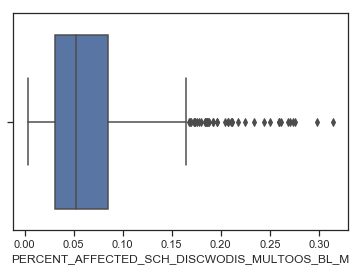

In [138]:
sns.boxplot(data[col].dropna())

## 2. Hist
Pros: Clearly shows distributions, and where majority of schools fall.

Cons: Unweighted by population, the plot fails to show *how many students* recieve suspensions, rather than just where schools of varying populations fall.

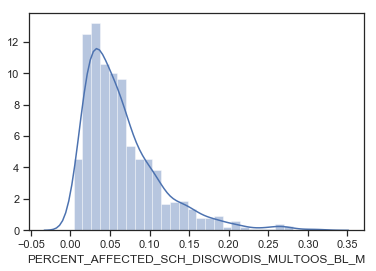

In [139]:
sns.distplot(data[col])

## 3. RugPlot
Pros: Shows every school in data sets as a distinct hair.

Cons: Difficult to differentiate schools in dense regions, still unclear the pop of each school.

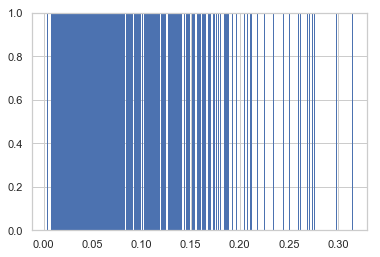

In [191]:
from matplotlib import colors as mcolors
sns.rugplot(data[col], height=1)

## 4. Violinplot
Pros: ?

Cons: Just a redundant version of the curve approximating the histogram distribution. Histogram is preferable.

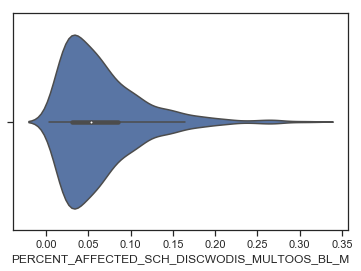

In [141]:
sns.violinplot(data[col])

# *Choose one continuous variable and one categorical variable, and plot them six different ways.*

## 1. ViolinPlot
Pros: Quick, smoothed, high-level comparison of distributions and mean.

Cons: Redundant accross y-axis.

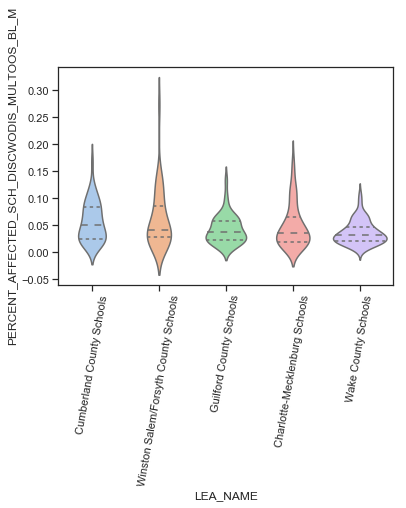

In [207]:
ax = sns.violinplot(x="LEA_NAME", y=col, data=biggest_districts_df, inner="quart")
for label in ax.get_xticklabels():
    label.set_rotation(80)

### less smoothing
Pros: invites more curiosity on specific data groups -- ie who are the "spear-head" schools in the extremes?

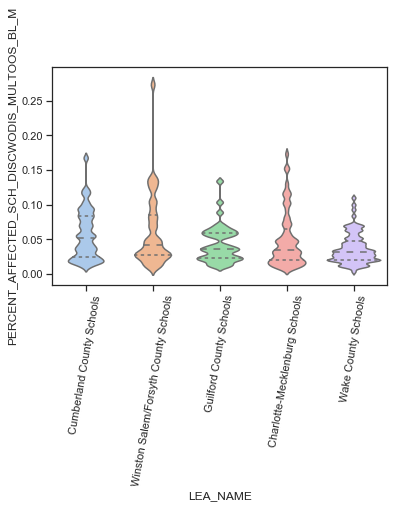

In [208]:
ax = sns.violinplot(x="LEA_NAME", y=col, data=biggest_districts_df, inner="quart", bw=0.1)
for label in ax.get_xticklabels():
    label.set_rotation(80)
    

## 2. Boxplot of Biggest 5 Districts
Pros: ...
Cons: This is just an inferior version of the violin plots, as it conveys just summary stats, and nothing about the distribution.

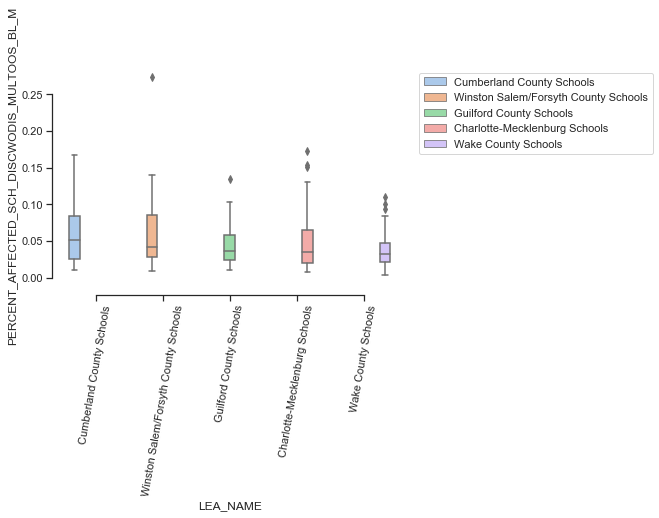

In [206]:
sns.set(style="ticks", palette="pastel")
ax = sns.boxplot(x="LEA_NAME", y=col,
            hue="LEA_NAME",
            data=biggest_districts_df)
sns.despine(offset=10, trim=True)
for label in ax.get_xticklabels():
    label.set_rotation(80)
    
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## 3. Dot plot with Black Male/Female Suspensions
Pros: Shows large density of easily comparable information via Tufte's "small multiples", grouped by school.

Cons: We've split each school's data across 3 variables, and we have no way of differentiating each school from another. Interactivity could help here

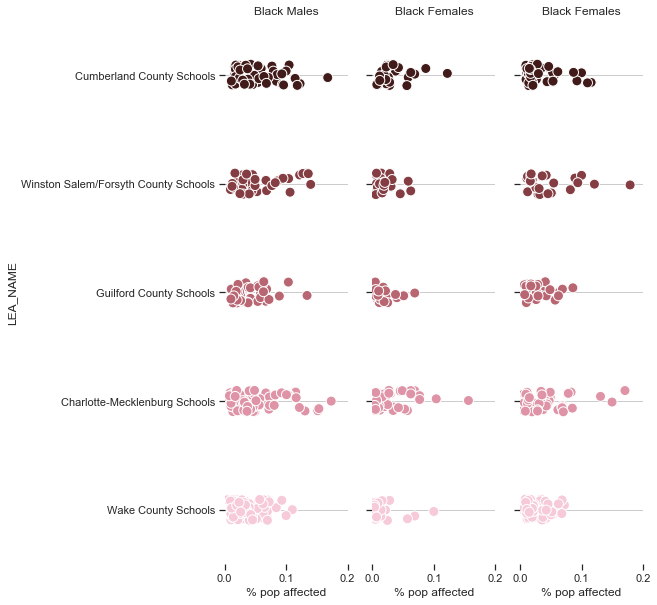

In [214]:
# Load the dataset
crashes = sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(biggest_districts_df,
                 x_vars=[col, col3_wh_m, col2], y_vars=['LEA_NAME'],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 0.2), xlabel="% pop affected")

# Use semantically meaningful titles for the columns
titles = ["Black Males", "Black Females", "Black Females"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## 4. Horizontal Boxplots, showing each school via Swarmplot overlays
Pros: descriptive stats typical of boxplot, with a little more window into where each school sits.

Cons: a hybrid of violin/boxplot, would work best if the swarmplots communicated something useful, like school pop size via size, or some factor via their color.

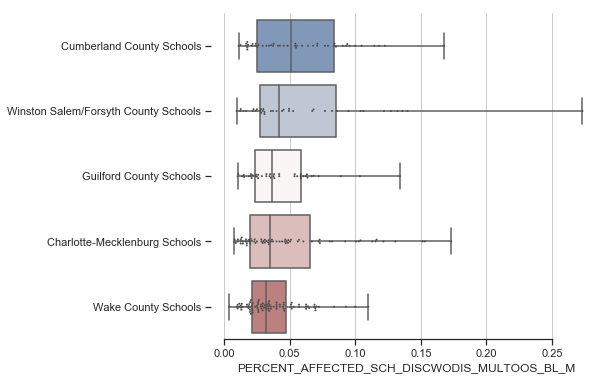

In [146]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x=col, y="LEA_NAME", data=biggest_districts_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x=col, y="LEA_NAME", data=biggest_districts_df,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

## 5. Scatter plot, colored by district
Pros: shows the distribution of white and black males.

Cons: __This is the improper use of this sort of graph.__ Density/overlap isn't meaningful.

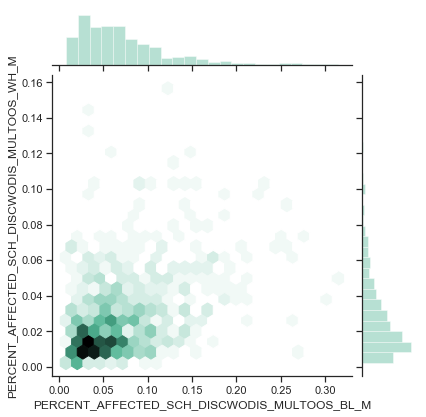

In [147]:
sns.set(style="ticks")

sns.jointplot(data[col], data[col3_wh_m], kind="hex", color="#4CB391")

### ... another attempt.
Pros: Shows every single school in all districts, with trend lines, as well as expanding uncertainty bars. Shows a clear skew towards black male higher suspension rates, but also some outliers where white male suspension is much higher.

Cons: Too cluttered, difficult to read.

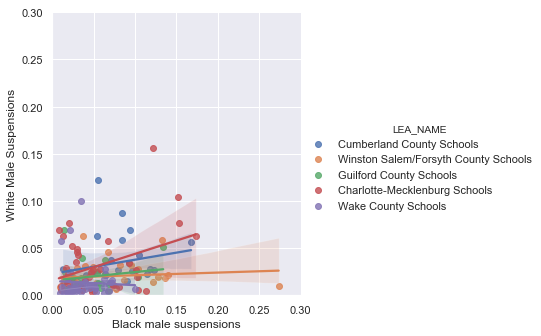

In [233]:
# sns.set()

# Plot sepal with as a function of sepal_length across days
data_cleaned = biggest_districts_df.dropna(subset=[col, col3_wh_m])
g = sns.lmplot(x=col, y=col3_wh_m, hue="LEA_NAME",
               truncate=True, height=5, data=data_cleaned)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Black male suspensions", "White Male Suspensions")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=[0, 0.3], ylim=[0, 0.3])
# plt.axis('equal')

## "Melt" data so every demographic is its own observation (row)

In [236]:
melted_df = pd.melt(biggest_districts_df.dropna(), id_vars=['LEA_NAME'], value_vars=[col, col3_wh_m])
melted_df

melted_df_all_schools = pd.melt(data.dropna(subset=[col, col3_wh_m]), id_vars=['LEA_NAME'], value_vars=[col, col3_wh_m])



## 6. Grouped Scatter plot of Two Demographics by District, with mean
Pros: Clearly communicates contrasting means between white and black male students, with a secondary semi-transparent layer of individual schools communicating distribution. Allows comparion within *and* accross schools, and gives a big picture view.

Cons: This plot should reall be *sorted* from highest to lowest average (I just can't quite figure out how to... :P)

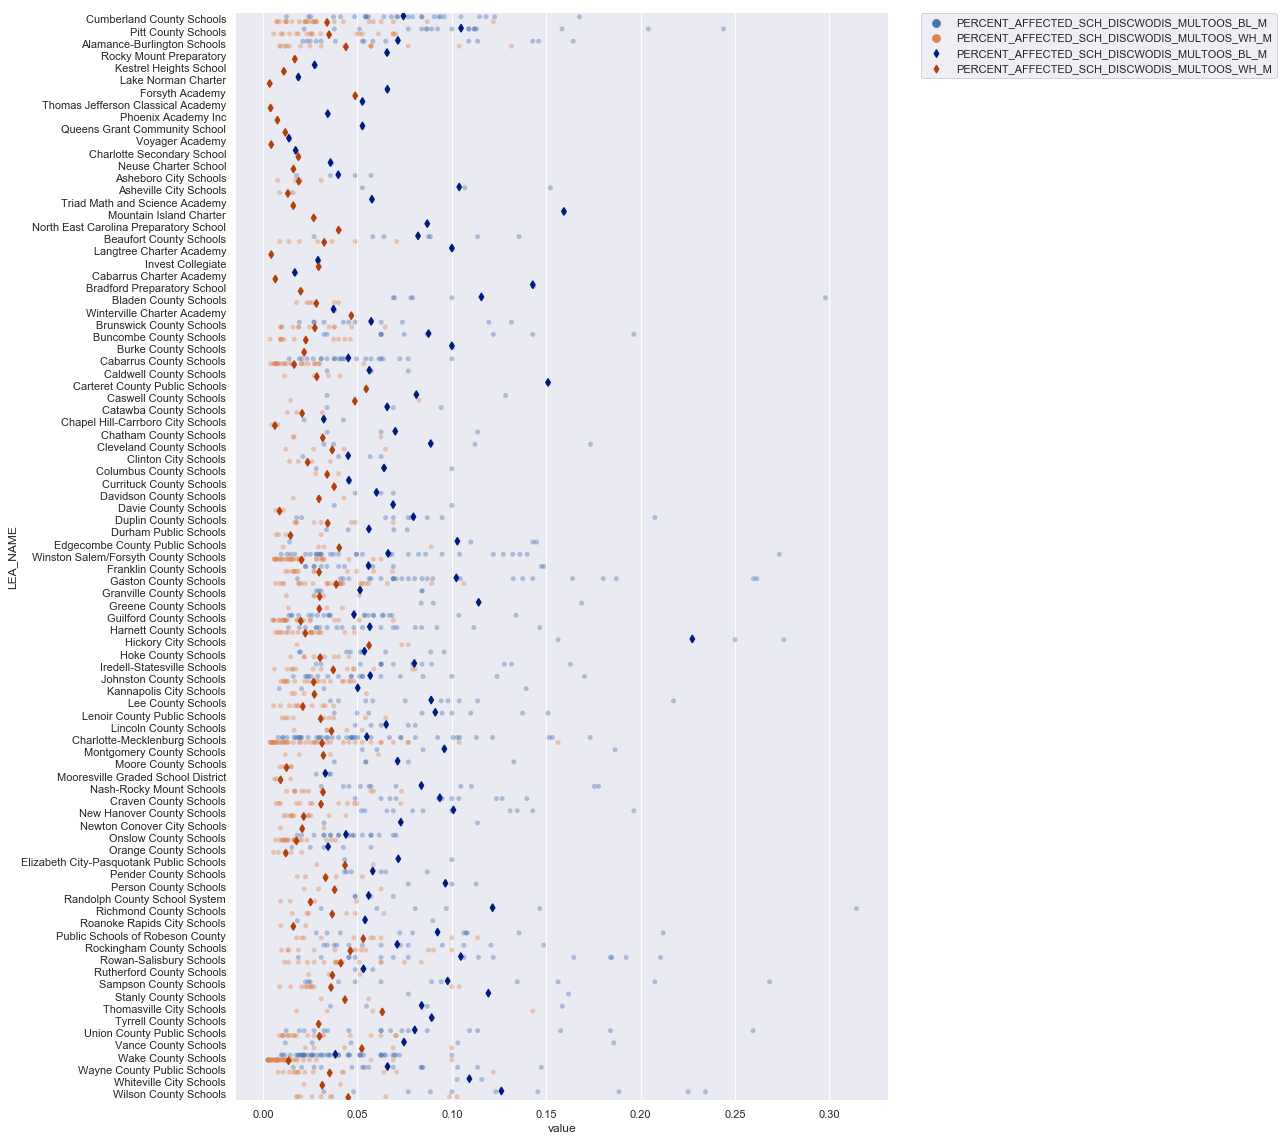

In [240]:
sns.set(rc={'figure.figsize':(11.7,20)})
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="value", y="LEA_NAME", hue="variable",
              data=melted_df_all_schools, dodge=True, jitter=False,
              alpha=.4, zorder=1)

# Show the means
sns.pointplot(x="value", y="LEA_NAME", hue="variable",
              data=melted_df_all_schools, dodge=.532, join=False,
              palette="dark", markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Suspensions",
          handletextpad=0,
          frameon=True)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Choose two continuous variables, and plot them three different ways.

## 1. Split violin plot, Black male w/ White Male
Pros: displays *and* fascilitates comparison between black and white male suspension rates. Notably, its clear how white suspension rates nearly entirely distribute at the bottom of the plot.

Cons: Currently, the average/std could be better displayed to enable comparison.

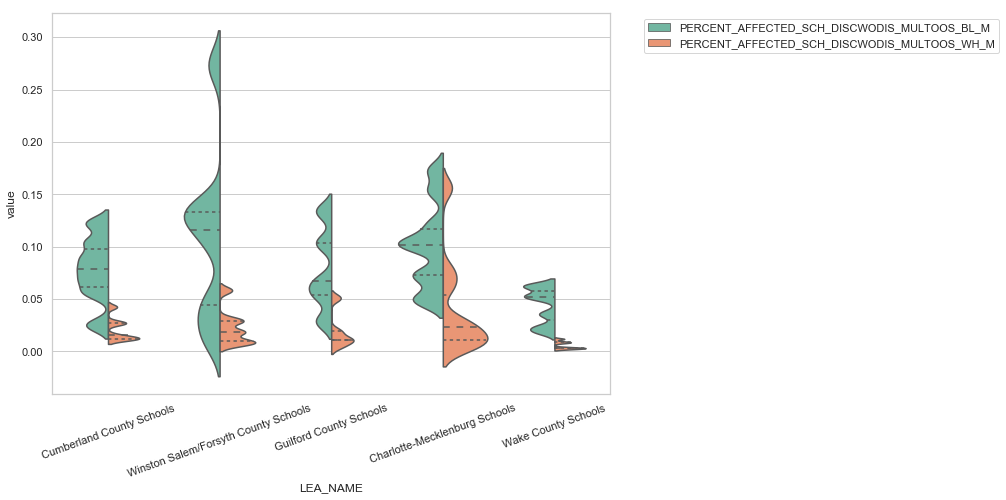

In [285]:
sns.set(style="whitegrid", rc={'figure.figsize': (10, 7)})

ax = sns.violinplot(x="LEA_NAME", y="value", hue="variable",
                    data=melted_df, palette="Set2", split=True,
                    scale="count", inner="quart",
                    scale_hue=False, bw=.2)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

for label in ax.get_xticklabels():
    label.set_rotation(20)

## 2. Scatter plot of Black VS White Male, with Rugplot on axes
Pros: Comparison *and* distribution

Cons: It's unclear what the plot is attempting to show. Other plots in this assignment much more effectively fascilitate comparison.

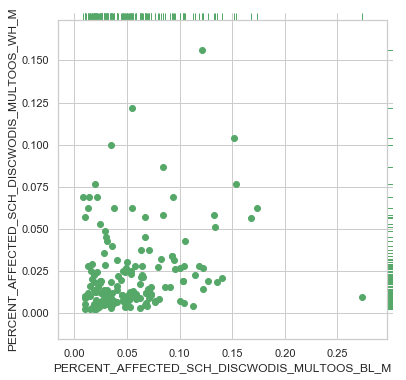

In [289]:
# Use JointGrid directly to draw a custom plot

grid = sns.JointGrid(biggest_districts_df[col], biggest_districts_df[col3_wh_m], space=0, height=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

## 3. Paired categorical plots of Suspenions %: By school and by Demographic
Pros: Gives quick, clear high-level comparison of suspension rates, as well as range of values.

Cons: You lose all finer grain details with individual schools, and again this isn't weighted by student population, which may change view.

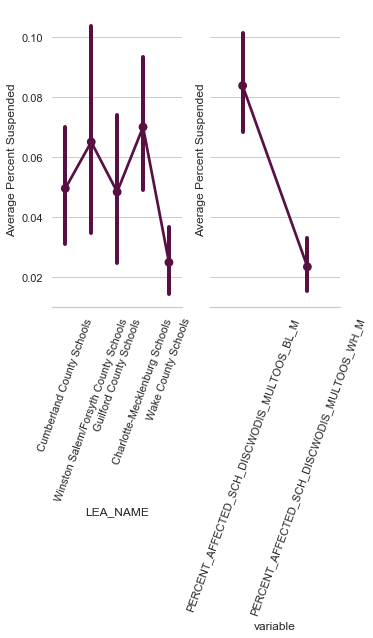

In [290]:
# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(melted_df, y_vars="value",
                 x_vars=["LEA_NAME", "variable"],
                 height=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1, errwidth=4, color="xkcd:plum")
g.set(ylabel="Average Percent Suspended")
sns.despine(fig=g.fig, left=True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(70)